In [45]:
import h5py
import numpy as np

# 1. Hyperparameter

In [46]:
# Timestep of Data
days = 360
data_len = 4 * days # 4 examples per day
choose_examples = range(data_len)

#clip height and clip Wide
clip_H, clip_W = 300, 300 


# Clip Image(Will then be updat)
H_min, H_max = 0, 767 # the height range of an img 
W_min, W_max = 0, 1151 # the width range of an img


# Smooth Pixel
smooth = 2
#H = int((H_max - H_min) / smooth) # num of height pixels
#W = int((W_max - W_min) / smooth) # num of width pixels
H = int((clip_H) / smooth) # num of height pixels
W = int((clip_W) / smooth) # num of width pixels

# 2. Read Data

In [63]:
# Data Path
climo_1979 = h5py.File('../data/climo_1979.h5')
climo_1980 = h5py.File('../data/climo_1980.h5')

# images: (1460,16,768,1152) numpy array, boxes: (1460,15,5) numpy array
images_1979, boxes_1979 = climo_1979['images'], climo_1979['boxes'] 
images_1980, boxes_1980 = climo_1980['images'], climo_1980['boxes']

# Original Image Shape
img_H, img_W = 768, 1152

# 3. Get labels of original image ready for optimal area and time finding

In [64]:
# Bounding Boxes
train_box = boxes_1979[choose_examples]
test_box = boxes_1980[choose_examples]

# Label Type
# 0 = Tropical Depression
# 1 = Tropical Cyclone
# 2 = Extratropical Cyclone
# 3 = Atmospheric River
label_type = 2

# Turn Bounding Boxes into Labels without clipping and smoothing
def box2label_ncs(boxes):
    global img_H, img_W, H_min, H_max, W_min, W_max, smooth, H, W
    # labeling
    label = np.zeros([boxes.shape[0], img_H, img_W])
    for i in range(boxes.shape[0]):
        for j in range(15):
            if boxes[i, j, 4] == label_type:
                ymin, xmin, ymax, xmax = boxes[i, j, 0:4]
                label[i, ymin:ymax+1 ,xmin:xmax+1] = 1
                
    return label
#     # clipping
#     label = label[:, H_min:H_max, W_min:W_max]
#     # smoothing
#     label_new = np.zeros([boxes.shape[0], H, W])
#     for i in range(H):
#         for j in range(W):
#             field = label[:, smooth*i:smooth*(i+1), smooth*j:smooth*(j+1)]
#             label_new[:, i, j] = np.mean(np.mean(field, axis=-1), axis=-1)
    
#     return (label_new > 0.5).astype(np.uint8)

train_label_ncs = box2label_ncs(train_box)
test_label_ncs = box2label_ncs(test_box)

# 3. Find the best area for prediction

In [65]:
sum_train_label = np.sum(train_label_ncs, axis=0)
optimal_x, optimal_y = 0,0
max_label_1 = 0
for origin_x in range(img_W-clip_W): #H,W = 768, 1152
    for origin_y in range(img_H-clip_H):
        temp = sum_train_label[origin_y:origin_y +clip_H,origin_x:origin_x +clip_W]
        temp = sum(sum(temp))
        #print(origin_x,origin_y)
        if temp > max_label_1:
            optimal_x = origin_x
            optimal_y = origin_y
            max_label_1 = temp
print("best zone x = {}, y = {}".format(optimal_x,optimal_y)) 

# update clip image
# Clip Image
# H_min, H_max = optimal_x, optimal_x + clip_H # the height range of an img 
# W_min, W_max = optimal_y, optimal_y + clip_W # the width range of an img

H_min, H_max = optimal_y, optimal_y + clip_H # the height range of an img 
W_min, W_max = optimal_x, optimal_x + clip_W # the width range of an img

best zone x = 525, y = 0


Train data with optimal area


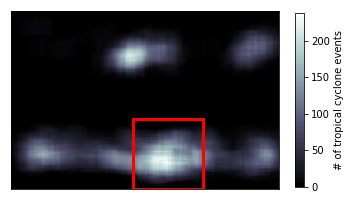

In [66]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
print("Train data with optimal area")
sum_train_label = np.sum(train_label_ncs, axis=0)
label_index = []
for i in range(img_H):
    for j in range(img_W):
        if (train_label_ncs[0, i, j] == 1):
            label_index.append((i, j))

origin_x_1, origin_y_1, box_width_1, box_height_1 = optimal_x, optimal_y, clip_H, clip_W
plt.imshow(sum_train_label, interpolation='nearest', cmap='bone', origin='lower')
plt.colorbar(shrink = .8).ax.set_ylabel('# of tropical cyclone events')
plt.xticks(())
plt.yticks(())
rect_1 = plt.Rectangle((origin_x_1, origin_y_1), box_width_1, box_height_1, linewidth=3, edgecolor='r', facecolor='none')

plt.gca().add_patch(rect_1)

# plt.savefig(f"label_{label_type}_train_area_choosing.pdf", bbox_inches='tight')
plt.show()

Train data with optimal area


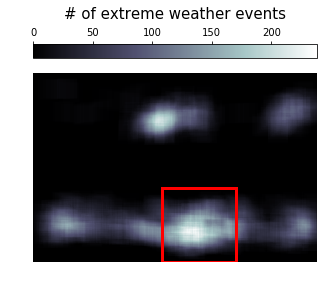

In [39]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

print("Train data with optimal area")
sum_train_label = np.sum(train_label_ncs, axis=0)
label_index = []
for i in range(img_H):
    for j in range(img_W):
        if (train_label_ncs[0, i, j] == 1):
            label_index.append((i, j))

origin_x_1, origin_y_1, box_width_1, box_height_1 = optimal_x, optimal_y, clip_H, clip_W

fig, ax = plt.subplots()
im = ax.imshow(sum_train_label, interpolation='nearest', cmap='bone', origin='lower')
ax.axis('off')
ax_driver = make_axes_locatable(ax)
cax = ax_driver.append_axes('top', size='7%', pad='8%')

cb = fig.colorbar(im, cax=cax, orientation='horizontal')
cax.xaxis.set_ticks_position('top')

rect_1 = plt.Rectangle((origin_x_1, origin_y_1), box_width_1, box_height_1, linewidth=3, edgecolor='r', facecolor='none')

ax.add_patch(rect_1)

plt.title('# of extreme weather events', y=2.5, fontdict = {'fontsize' : 15})
# plt.savefig(f"label_{label_type}_train_area_choosing_v3.pdf", bbox_inches='tight')
plt.show()

Test data with optimal area


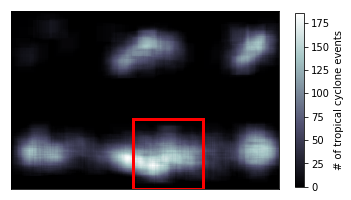

In [40]:

print("Test data with optimal area")
sum_test_label = np.sum(test_label_ncs, axis=0)
'''
label_index = []
for i in range(img_H):
    for j in range(img_W):
        if (train_label_ncs[0, i, j] == 1):
            label_index.append((i, j))
'''
origin_x_1, origin_y_1, box_width_1, box_height_1 = optimal_x, optimal_y, clip_H, clip_W
plt.imshow(sum_test_label, interpolation='nearest', cmap='bone', origin='lower')
plt.colorbar(shrink = .8).ax.set_ylabel('# of tropical cyclone events')
plt.xticks(())
plt.yticks(())
rect_1 = plt.Rectangle((origin_x_1, origin_y_1), box_width_1, box_height_1, linewidth=3, edgecolor='r', facecolor='none')

plt.gca().add_patch(rect_1)

# plt.savefig(f"label_{label_type}_test_area_choosing.pdf", bbox_inches='tight')
plt.show()

# 4. Find the best time for prediction ( based on optimal area )

In [67]:
months = int(days/30)
max_month_label = 0
max_month = 0
true_num = []

for i in range(months) :
    temp_label_ncs = train_label_ncs[120*i:120*i + 120]
    sum_temp_label = np.sum(temp_label_ncs, axis=0)
    sum_temp_label = sum_temp_label[optimal_y:optimal_y +clip_H,optimal_x:optimal_x +clip_W]
    true_num.append(sum(sum(sum_temp_label)))
    print(sum(sum(sum_temp_label)))
    if sum(sum(sum_temp_label)) > max_month_label:
        max_month_label = sum(sum(sum_temp_label))
        max_month = i
print("{}月極端氣候最多".format(max_month+1))


409941.0
725570.0
643419.0
772921.0
664911.0
838576.0
707420.0
625077.0
418756.0
506584.0
531501.0
304560.0
6月極端氣候最多


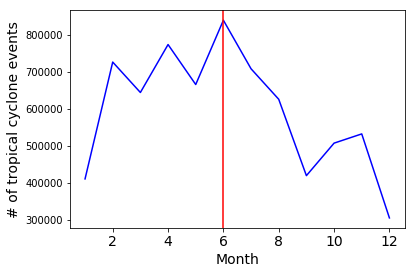

In [68]:
Months = [1,2,3,4,5,6,7,8,9,10,11,12]
plt.plot(Months,true_num, color = 'b')
plt.xlabel('Month', fontsize=14)
plt.ylabel('# of tropical cyclone events', fontsize=14)
# plt.title("Monthly extreme weather number")
plt.axvline(max_month+1, 0, 1, color = 'r')
plt.gca().tick_params(axis = 'x', which = 'major', labelsize = 14)
# plt.legend()
# plt.savefig(f"label_{label_type}_train_month_choosing_v2.pdf", bbox_inches='tight')
plt.show()

Train data with optimal area and time
x = 361 
y = 373
month : 9月


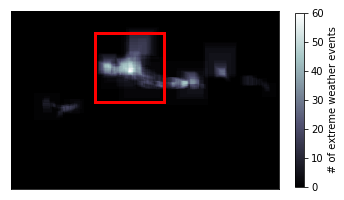

In [32]:
print("Train data with optimal area and time")
print("x = {} \ny = {}".format(optimal_x,optimal_y))
# print("month : {}月".format(max_month+1))
# sum_train_label = np.sum(train_label_ncs[120*max_month:120*max_month+120], axis=0)
print("month : {}月".format(max_month+1))
sum_train_label = np.sum(train_label_ncs[120*(max_month-1):120*max_month], axis=0)

origin_x_1, origin_y_1, box_width_1, box_height_1 = optimal_x, optimal_y, clip_H, clip_W
plt.imshow(sum_train_label, interpolation='nearest', cmap='bone', origin='lower')
plt.colorbar(shrink = .8).ax.set_ylabel('# of extreme weather events')
plt.xticks(())
plt.yticks(())
rect_1 = plt.Rectangle((origin_x_1, origin_y_1), box_width_1, box_height_1, linewidth=3, edgecolor='r', facecolor='none')
plt.gca().add_patch(rect_1)

# plt.savefig(f"label_{label_type}_train_area(jun).pdf", bbox_inches='tight')
plt.show()

Train data with optimal area and time
x = 525 
y = 0
month : 6月


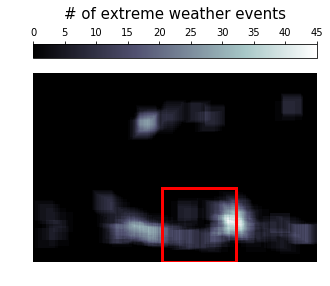

In [44]:
print("Train data with optimal area and time")
print("x = {} \ny = {}".format(optimal_x,optimal_y))
# print("month : {}月".format(max_month+1))
# sum_train_label = np.sum(train_label_ncs[120*max_month:120*max_month+120], axis=0)
print("month : {}月".format(max_month+1))
sum_train_label = np.sum(train_label_ncs[120*(max_month-1):120*max_month], axis=0)

origin_x_1, origin_y_1, box_width_1, box_height_1 = optimal_x, optimal_y, clip_H, clip_W

fig, ax = plt.subplots()
im = ax.imshow(sum_train_label, interpolation='nearest', cmap='bone', origin='lower')
ax.axis('off')
ax_driver = make_axes_locatable(ax)
cax = ax_driver.append_axes('top', size='7%', pad='8%')

cb = fig.colorbar(im, cax=cax, orientation='horizontal')
cax.xaxis.set_ticks_position('top')

rect_1 = plt.Rectangle((origin_x_1, origin_y_1), box_width_1, box_height_1, linewidth=3, edgecolor='r', facecolor='none')

ax.add_patch(rect_1)

plt.title('# of extreme weather events', y=2.5, fontdict = {'fontsize' : 15})

# plt.savefig(f"label_{label_type}_train_area(jun)_v3.pdf", bbox_inches='tight')
plt.show()

Test data with optimal area and time
x = 525 
y = 0
month : 6月


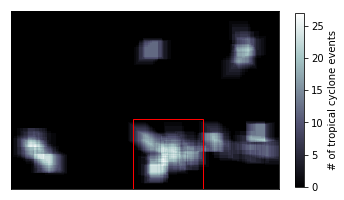

In [44]:
print("Test data with optimal area and time")
print("x = {} \ny = {}".format(optimal_x,optimal_y))
# print("month : {}月".format(max_month+1))
# sum_train_label = np.sum(test_label_ncs[120*max_month:120*max_month+120], axis=0)
print("month : {}月".format(max_month+1))
sum_train_label = np.sum(test_label_ncs[120*(max_month-1):120*max_month], axis=0)


label_index = []
for i in range(img_H):
    for j in range(img_W):
        if (train_label_ncs[0, i, j] == 1):
            label_index.append((i, j))

origin_x_1, origin_y_1, box_width_1, box_height_1 = optimal_x, optimal_y, clip_H, clip_W
plt.imshow(sum_train_label, interpolation='nearest', cmap='bone', origin='lower')
plt.colorbar(shrink = .8).ax.set_ylabel('# of tropical cyclone events')
plt.xticks(())
plt.yticks(())
rect_1 = plt.Rectangle((origin_x_1, origin_y_1), box_width_1, box_height_1, linewidth=1, edgecolor='r', facecolor='none')
plt.gca().add_patch(rect_1)

# plt.savefig(f"label_{label_type}_test_area(sep).pdf")
plt.show()

# 5. Clip the optimal area and split train and test data

In [13]:
# Bounding Boxes
train_box = boxes_1979[choose_examples]
test_box = boxes_1980[choose_examples]

# Label Type
# 0 = Tropical Depression
# 1 = Tropical Cyclone
# 2 = Extratropical Cyclone
# 3 = Atmospheric River
label_type = 2

# Turn Bounding Boxes into Labels
def box2label(boxes):
    global img_H, img_W, H_min, H_max, W_min, W_max, smooth, H, W
    # labeling
    label = np.zeros([boxes.shape[0], img_H, img_W])
    for i in range(boxes.shape[0]):
        for j in range(15):
            if boxes[i, j, 4] == label_type:
                ymin, xmin, ymax, xmax = boxes[i, j, 0:4]
                label[i, ymin:ymax+1 ,xmin:xmax+1] = 1
    # clipping
    label = label[:, H_min:H_max, W_min:W_max]
    # smoothing
    label_new = np.zeros([boxes.shape[0], H, W])
    for i in range(H):
        for j in range(W):
            field = label[:, smooth*i:smooth*(i+1), smooth*j:smooth*(j+1)]
#             temp_mean = np.mean(np.mean(field, axis=-1), axis=-1)
            label_new[:, i, j] = np.mean(np.mean(field, axis=-1), axis=-1)
#             print(field.shape)
#             print(temp_mean.shape)
#             print(label_new[:, i, j].shape)
#             return
#             if np.any(np.isnan(temp_mean)):
#                 label_new[:, i, j] = np.zeros(temp_mean.shape)
#             else:
#                 label_new[:, i, j] = temp_mean
    
    return (label_new > 0.5).astype(np.uint8)

train_label = box2label(train_box)
test_label = box2label(test_box)

# Smooth Images
def smooth_img(img):
    global smooth, H, W
    
    img_smooth = np.zeros([img.shape[0], 16, H, W], dtype=np.float32)
    for i in range(H):
        for j in range(W):
            field = img[:, :, smooth*i:smooth*(i+1), smooth*j:smooth*(j+1)]
#             temp_mean = np.nanmean(np.nanmean(field, axis=-1), axis=-1)
            img_smooth[:, :, i, j] = np.nanmean(np.nanmean(field, axis=-1), axis=-1)
#             print(field.shape)
#             print(temp_mean.shape)
#             print(img_smooth[:, :, i, j].shape)
#             return
#             if np.any(np.isnan(temp_mean)):
#                 img_smooth[:, :, i, j] = np.zeros(temp_mean.shape)
#             else:
#                 img_smooth[:, :, i, j] = temp_mean
    
    return np.transpose(img_smooth, [0,2,3,1]) # shape = (T, H, W, 16)

train_img = smooth_img(images_1979[choose_examples, :, H_min:H_max, W_min:W_max])
test_img = smooth_img(images_1980[choose_examples, :, H_min:H_max, W_min:W_max])

# 6. Clip the optimal month

In [14]:
# Training and Testing
# train_label_1 = train_label[max_month*120:max_month*120+120]
# test_label_1 = test_label[max_month*120:max_month*120+120]
# train_img_1 = train_img[max_month*120:max_month*120+120]
# test_img_1 = test_img[max_month*120:max_month*120+120]

# Validation
train_label_1 = train_label[(max_month-1)*120:max_month*120]
test_label_1 = test_label[(max_month-1)*120:max_month*120]
train_img_1 = train_img[(max_month-1)*120:max_month*120]
test_img_1 = test_img[(max_month-1)*120:max_month*120]

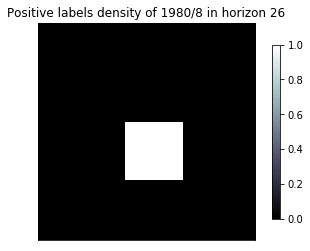

In [22]:
h = 26

plt.title('Positive labels density of 1980/8 in horizon {}'.format(h))
plt.imshow(test_label_1[h], interpolation='nearest', cmap='bone', origin='lower')
plt.colorbar(shrink = .8)
plt.xticks(())
plt.yticks(())
plt.show()

# 7. Saving Preprocessed Data

In [23]:
# name of the folder
# folder_name = 'apr_30_days_x_111_y_238_label_0'
# folder_name = 'aug_30_days_x_361_y_373'
folder_name = 'may_30_days_x_525_y_000_label_2'

np.save('../data_preprocess/{}/train_label_smooth_{}'.format(folder_name,smooth), train_label_1)
np.save('../data_preprocess/{}/test_label_smooth_{}'.format(folder_name,smooth), test_label_1)
np.save('../data_preprocess/{}/train_img_smooth_{}'.format(folder_name,smooth), train_img_1)
np.save('../data_preprocess/{}/test_img_smooth_{}'.format(folder_name,smooth), test_img_1)
